In [131]:
# import libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import warnings

In [89]:
# set global parameters
sns.set(style='darkgrid') 
pd.set_option('display.precision', 2)
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore')

In [90]:
# read csv file and print our 5 rows
df = pd.read_csv('C:/MISIS_DataEngineering/ML/hw2/Python_analysis/credit_score_cleaned_train.csv')
df.loc[0:2].style

,id,customer_id,month,name,age,ssn,occupation,annual_income,monthly_inhand_salary,credit_history_age,total_emi_per_month,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.120000,1824.843400,89,49.574947,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan']",3,7,11.270000,4,Good,809.980000,26.822620,No,80.415300,High_spent_Small_value_payments,312.494080,2
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.120000,1824.843400,93,49.574947,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan']",-1,7,11.270000,4,Good,809.980000,31.944960,No,118.280220,Low_spent_Large_value_payments,284.629150,2
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.120000,1824.843400,91,49.574947,3,4,3,4,"['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan']",3,7,11.270000,4,Good,809.980000,28.609352,No,81.699524,Low_spent_Medium_value_payments,331.209870,2


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96696 entries, 0 to 96695
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        96696 non-null  object 
 1   customer_id               96696 non-null  object 
 2   month                     96696 non-null  object 
 3   name                      96696 non-null  object 
 4   age                       96696 non-null  int64  
 5   ssn                       96696 non-null  object 
 6   occupation                96696 non-null  object 
 7   annual_income             96696 non-null  float64
 8   monthly_inhand_salary     96696 non-null  float64
 9   credit_history_age        96696 non-null  int64  
 10  total_emi_per_month       96696 non-null  float64
 11  num_bank_accounts         96696 non-null  int64  
 12  num_credit_card           96696 non-null  int64  
 13  interest_rate             96696 non-null  int64  
 14  num_of

In [92]:
unique_classes_list = df['credit_score'].unique()
print(f'The unique classes in the target column are: {unique_classes_list}')

The unique classes in the target column are: [2 1 0]


In [93]:
# Check for NaN values in each column
nan_columns = df.isna().sum()

# Filter columns with NaN values
nan_columns = nan_columns[nan_columns > 0]

print(f"Columns with NaN values:\n{nan_columns}")
print(f"Number of columns with NaN values: {nan_columns.count()}")

Columns with NaN values:
Series([], dtype: int64)
Number of columns with NaN values: 0


### Sklearn (Classification)

In [159]:
# global variables
SEED = 777

In [160]:
# Fit the models, transform and return prediction
class TypeSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [161]:
# transformer pipline
transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        
        ('boolean', Pipeline([('selector', TypeSelector('bool')),])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer', SimpleImputer())
            
        ])),  # numericals close
    ])),  # features close
])  # pipeline close

In [163]:
# estimator pipeline
estimators = [
    ('CatBoost Classifier', CatBoostClassifier(
        eval_metric='MultiClass', random_state=SEED, verbose=0)
    ),
    
    ('Random Forest', RandomForestClassifier(
        criterion='entropy', max_depth=5, random_state=SEED)
    ),
    
    ('LGBM Classifier', LGBMClassifier(
        objective='multiclass', verbosity=0, random_state=SEED)
    ),
    
    ('Gradient Boosting', GradientBoostingClassifier(
        criterion='friedman_mse', max_depth=5, random_state=SEED)
    ),
    
    ('XGB Classifier', XGBClassifier(
        eval_metric='mlogloss', max_depth=5, verbose=0, random_state=SEED)
    )
]

In [165]:
# models pipeline
def pipe_builder(X, y, estimators):
    pipes = {}
    for model in estimators:            
        pipe = Pipeline(steps=[('data_prep', transformer), model])
        pipe.fit(X, y)
        pipes[pipe.steps[1][0]] = pipe

    return pipes

In [166]:
# train models and show ML metrics
def get_metrics(X, y, estimators):
    pipes = pipe_builder(X=X, y=y, estimators=estimators)
    models = list(list(zip(*estimators))[0])
    
    scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

    for model in models:
        score = cross_validate(
            pipes[model], 
            X, y, 
            cv=KFold(5), 
            scoring=scoring
        )
        f1 = round(max(score['test_f1_macro']), 2)
    
        print(f'F1 Score     {model}: {f1}')
        print('----------------------------------------')

### ML models

In [167]:
# create features and target
X = df.drop(['credit_score'], axis=1)
y = df['credit_score']

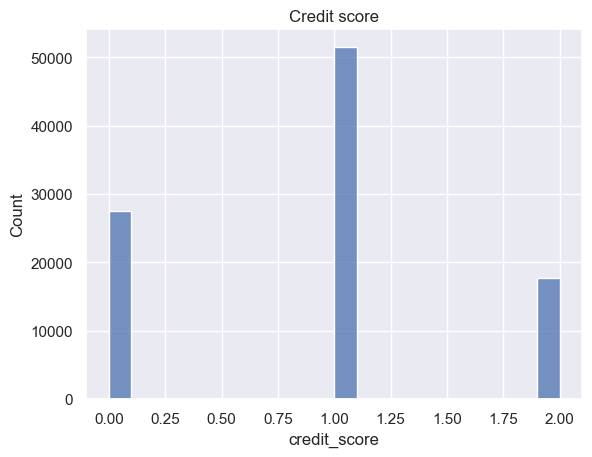

In [173]:
sns.histplot(data=df, x="credit_score", bins=20).set(title='Credit score');

In [ ]:
# print out metrics Blood_glucose
print('#############')
print('Credit_score')
print('#############')
get_metrics(X=X, y=y, estimators=estimators)

#############
Credit_score
#############
F1 Score     CatBoost Classifier: 0.66
----------------------------------------
F1 Score     Random Forest: 0.58
----------------------------------------
F1 Score     LGBM Classifier: 0.67
----------------------------------------
F1 Score     Gradient Boosting: 0.67
----------------------------------------
F1 Score     XGB Classifier: 0.66
----------------------------------------


### Grid Search

In [170]:
lgbm = estimators[2]
lgbm

('LGBM Classifier',
 LGBMClassifier(objective='multiclass', random_state=777, verbosity=0))

In [ ]:
pipe = Pipeline(steps=[('data_prep', transformer), lgbm])
pipe.fit(X, y)

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer())]))]))])),
                ('LGBM Classifier',
                 LGBMClassifier(objective='multiclass', random_state=777,
                                verbosity=0))])

In [172]:
f1_scorer = {'f1_macro': make_scorer(f1_score, average='macro')}

In [180]:
# Define the parameter grid
param_grid = {
    'LGBM Classifier__num_leaves': [31, 50, 70],
    'LGBM Classifier__max_depth': [5, 10, 15],
    'LGBM Classifier__learning_rate': [0.01, 0.05, 0.1],
    'LGBM Classifier__n_estimators': [100, 200, 300]
}

In [181]:
# Initialize GridSearchCV with F1 score as the scoring metric
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, 
scoring=f1_scorer, cv=5, verbose=1, n_jobs=-1, refit='f1_macro')

In [ ]:
# Fit GridSearchCV
grid_search.fit(X, y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_prep',
                                        Pipeline(steps=[('features',
                                                         FeatureUnion(n_jobs=1,
                                                                      transformer_list=[('boolean',
                                                                                         Pipeline(steps=[('selector',
                                                                                                          TypeSelector(dtype='bool'))])),
                                                                                        ('numericals',
                                                                                         Pipeline(steps=[('selector',
                                                                                                          TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                                         ('imputer',
                                                                                                          SimpleImputer())]))]))])),
                                       ('LGBM Classifier',
                                        LGBMClassifier(objective='multiclass',
                                                       random_state=777,
                                                       verbosity=0))]),
             n_jobs=-1,
             param_grid={'LGBM Classifier__learning_rate': [0.01, 0.05, 0.1],
                         'LGBM Classifier__max_depth': [5, 10, 15],
                         'LGBM Classifier__n_estimators': [100, 200, 300],
                         'LGBM Classifier__num_leaves': [31, 50, 70]},
             refit='f1_macro',
             scoring={'f1_macro': make_scorer(f1_score, average=macro)},
             verbose=1)

In [184]:
# Get the best parameters and best score
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'LGBM Classifier__learning_rate': 0.05, 'LGBM Classifier__max_depth': 15, 'LGBM Classifier__n_estimators': 100, 'LGBM Classifier__num_leaves': 31}


### Predictions

In [187]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [196]:
# Get the best estimator
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer())]))]))])),
                ('LGBM Classifier',
                 LGBMClassifier(learning_rate=0.05, max_depth=15,
                                objective='multiclass', random_state=777,
                                verbosity=0))])

In [188]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [194]:
# Calculate and print the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='weighted')

In [195]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.72
Precision: 0.71
Recall: 0.69
F1 Score: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70      5381
           1       0.73      0.79      0.76     10378
           2       0.63      0.62      0.62      3581

    accuracy                           0.72     19340
   macro avg       0.71      0.69      0.69     19340
weighted avg       0.72      0.72      0.72     19340

